In [3]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [11]:
samplerate, data = wavfile.read('sonido-presion/presion_segmento_1.wav')

In [13]:
path = 'sonido-presion/'
files = {i: {'presion': [], 'sonido': []} for i in range(1,4)}

for i,file in enumerate(os.listdir(path)):
  file_name = str(os.path.splitext(file)[0])
  segmento = int(file_name.split('_')[2])
  param = file_name.split('_')[0]

  sample_rate, data = wavfile.read(os.path.join(path, file))
  print(f'La frecuencia de muestreo del segmento {segmento} de {file_name.split("_")[0]} es {sample_rate}. N = {len(data)}')
  files[segmento][param] = data.astype(np.int32)

La frecuencia de muestreo del segmento 1 de presion es 44150. N = 38976
La frecuencia de muestreo del segmento 2 de presion es 44150. N = 43400
La frecuencia de muestreo del segmento 3 de presion es 44150. N = 24472
La frecuencia de muestreo del segmento 1 de sonido es 44150. N = 38976
La frecuencia de muestreo del segmento 2 de sonido es 44150. N = 43400
La frecuencia de muestreo del segmento 3 de sonido es 44150. N = 24472


In [15]:
frec_m = 44150
dt_m = 1/frec_m
N  = len(files[1]['presion'])
t_m = np.arange(0, N) * dt_m

print(f'dt muestreo: {dt_m} \n tiempo total de medición {t_m[-1]} ')

dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.8827859569648924 


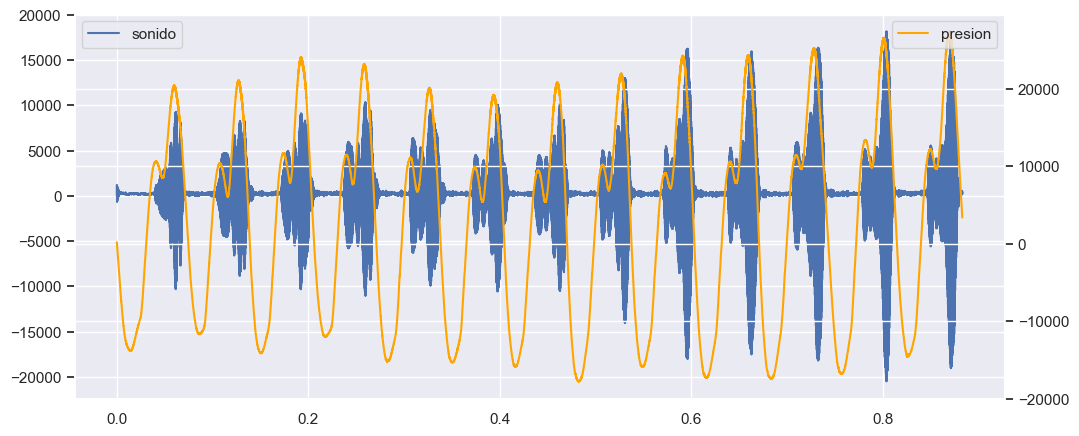

In [19]:


fig,ax = plt.subplots(figsize=(12,5))

ax.plot(t_m,files[1]['sonido'], label = 'sonido')
ax.plot()
plt.legend(loc = 0)

ax2=ax.twinx()
ax2.tick_params(axis='both')
ax2.plot(t_m,files[1]['presion'], label = 'presion', color = 'orange')
plt.legend(loc=1)
plt.show()


In [21]:
dt = 1/884000 # este es el dt de la simulación
t = np.arange(0, t_m[-1], dt)

In [23]:
dif = list(set(t).difference(t_m))
intersec = list(set(t_m).intersection(t))
print(len(dif), len(intersec))
#claramente nos son multiplos el uno del otro

780366 17


In [25]:
# la cantidad de puntos que quiero tener:
dt_m/dt * N
len(t)

780383

### Interpolo $\beta$

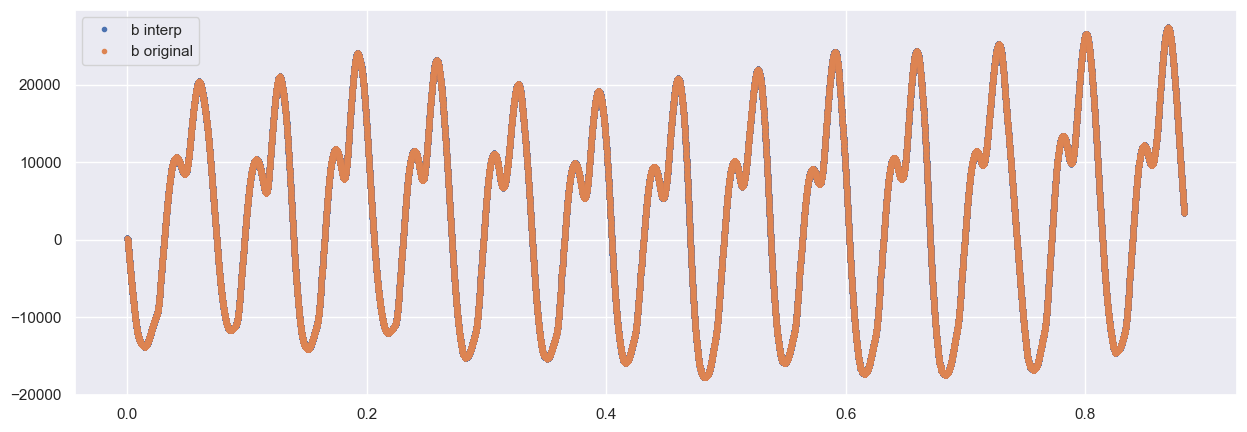

In [27]:
from scipy.interpolate import interp1d
import numpy as np

p = files[1]['presion']
s = files[1]['sonido']

interp_func = interp1d(t_m, p)

b_interpolado = interp_func(np.linspace(0, t_m[-1],len(t) ))
plt.figure(figsize= (15,5))
plt.plot(t,b_interpolado, '.', label = "b interp")
plt.plot(t_m, p, '.', label = "b original")
plt.legend()
plt.show()

Determino el offset $\beta = p + offset$ tal que los valores de $\beta$ sean negativos cuando el sonido es nulo

In [29]:

def plot1(offset):
    fig,ax = plt.subplots(figsize=(12,5))

    b = p + offset
    ax.plot(t_m,s, label = 'sonido', color = 'blue')
    ax.plot(t_m[b<0],s[b<0],'.', color = 'red')
    ax.plot()
    plt.legend(loc = 0)

    ax2=ax.twinx()
    ax2.tick_params(axis='both')
    ax2.plot(t_m,b, label = "presion")
    ax2.plot(t_m[b<0],b[b<0], color = 'red')
    ax2.axhline(y=0, color='black', linestyle='-')

    plt.legend(loc=1)
    plt.show()

#params
offset = widgets.FloatSlider(value=1000 , min= 0 , max= 16000, step= 1e3, description='offset')

# linkeo el slider con los graficos
output1 = widgets.interactive_output(plot1, {'offset': offset})

# muestro los outputs#
display(offset, output1)


FloatSlider(value=1000.0, description='offset', max=16000.0, step=1000.0)

Output()

offset de 9k es razonable

Con $\beta$ interpolado ahora corro la simulación.

### Simulación

In [21]:

#funcion del sistema de ecuaciones
def f(X, t, params):
    w, x = X
    k, c, delta, beta = params

    gamma = 1e4 #reescaleo
    mu = 1e5

    f_w = -gamma * k / mu * (x + delta / k)
    f_x = gamma * mu * (w - c * x**3 / mu + beta * x / mu )
    return np.array([f_w,f_x])

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X


In [23]:

#condiciones iniciales PREGUNTAR
x0 = 1
w0 = 0
X0 = np.array([w0, x0])

#parametros
k, c, f0= 1 , 1, 0



In [33]:

colors = ['green','red','black','blue']
N_i = len(t)
b_ = (b_interpolado + 9000)*1e-4 #unidades!!
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0
# Integración
for j in range(N_i):
    params = [k, c, f0, b_[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)


Text(0.5, 0.98, 'Evolución del sistema con $\\beta$ de mediciones')

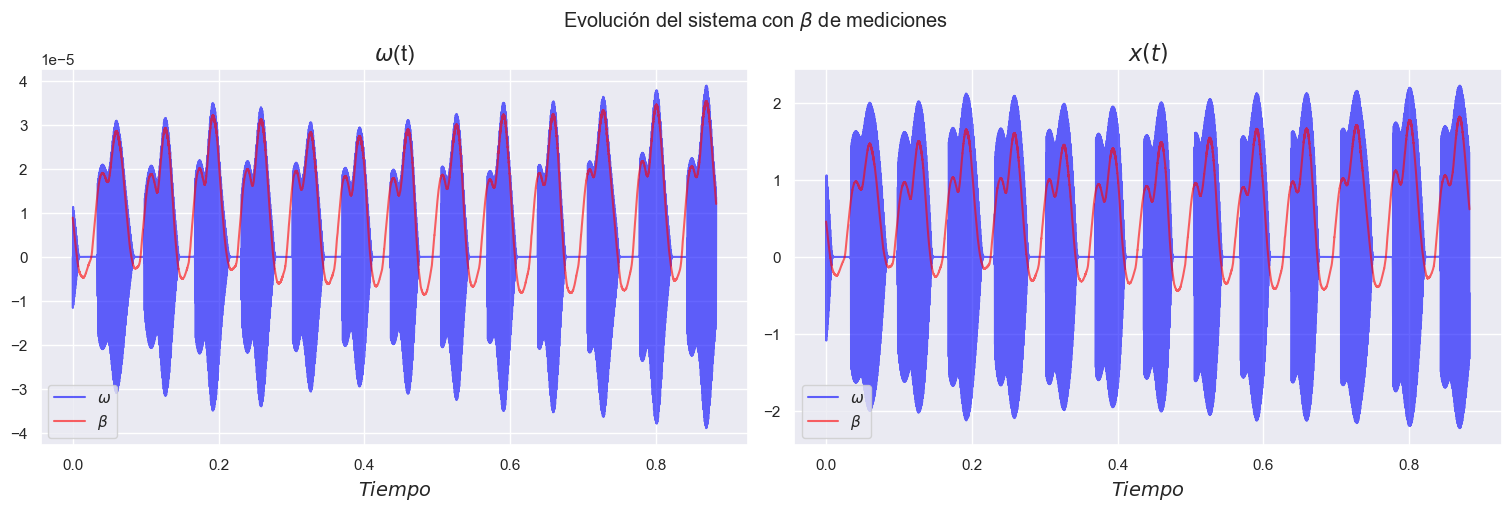

In [31]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True,
                                sharey=False)
#ploteo
ax1.plot(t,Xs[:,0][:-1],alpha = .60, color=colors[3], label = r'$\omega$')
ax1.plot(t,b_*max(Xs[:,0])/4,alpha = .60, color=colors[1], label = r'$\beta$')
ax1.legend(loc=0)

ax2.plot(t,Xs[:,1][:-1],alpha = .60, color=colors[3], label = r'$\omega$')
ax2.plot(t,b_/2,alpha = .60, color=colors[1], label = r'$\beta$')
ax2. legend(loc=0)

ax1.set_xlabel('$Tiempo$', fontsize=14)
ax1.set_title(r'$\omega$(t)', fontsize=16)
ax2.set_xlabel('$Tiempo$', fontsize=14)
ax2.set_title(r'$x(t)$', fontsize=16)


fig.suptitle(r"Evolución del sistema con $\beta$ de mediciones")

comparo los datos de mediiciones con los de la simulación.
Para eso tengo que agarrar la cantidad de puntos de la medición

In [39]:
print(f'N de la simulacion: {len(t)} \n',f'N de los datos: {len(t_m)} \n', f' Tomo de la simulación 1 dato cada {len(t)/len(t_m)}')

N de la simulacion: 780383 
 N de los datos: 38976 
  Tomo de la simulación 1 dato cada 20.02214183087028


In [41]:
#t_ = [t[i] for i in range(len(t)) if i % 20 == 0]
t_s = []
s_s = []

s_sim = Xs[:,1][:-1]

for i in range(len(t)):
  if i % 20 == 0:
    t_s.append(t[i])
    s_s.append(s_sim[i])
t_s = t_s[:len(t_m)]
s_s = s_s[:len(t_m)]

s_m = s/5e3 #unidades!!!
print(len(t_s), len(s_s), len(t_m))

38976 38976 38976


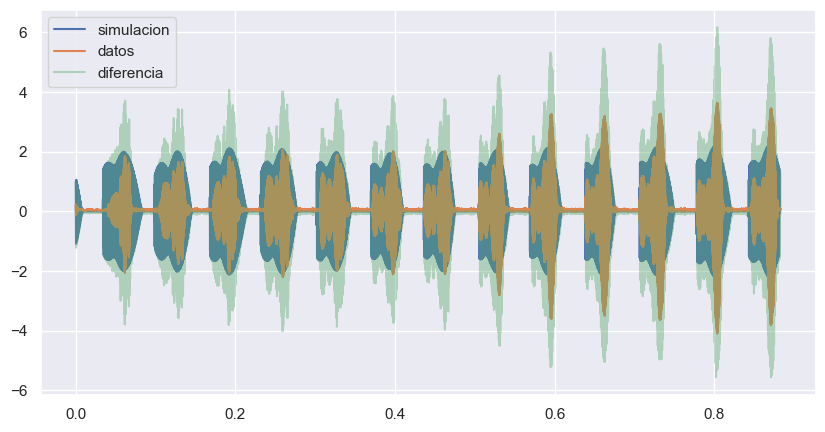

In [47]:

plt.figure(figsize=(10,5))
plt.plot(t_s,s_s, label = 'simulacion')
plt.plot(t_m,s_m, label = 'datos')
plt.plot(t_m,s_s-s_m,alpha = 0.4, label = 'diferencia')
plt.legend()



### Filtro pasa banda

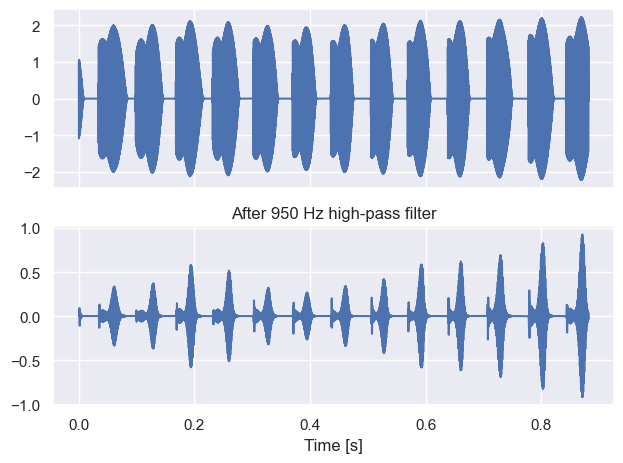

In [88]:

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t_s, s_s)
fc = 950
sos = signal.butter(10, fc, 'lp', fs=44150, output='sos')
filtered = signal.sosfilt(sos, s_s)
ax2.plot(t_s, filtered)
ax2.set_title(f'After {fc} Hz high-pass filter')
ax2.set_xlabel('Time [s]')
plt.tight_layout()
plt.show()

In [1]:
import ipywidgets as widgets
from IPython.display import display
output = widgets.Output()

text_input = widgets.Text(
    value='',  # Initial 
    description='Type here:',  # Label for the text input
    disabled=False  #  to be editable
)

# Function to handle changes in the text input
def on_text_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            output.clear_output() # from 'Output widgets: leveraging Jupyter’s display system' https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html
            print(f"You entered: {change['new']}")

# Observe changes in the text input widget
text_input.observe(on_text_change, names='value')

display(output, text_input)

Output()

Text(value='', description='Type here:')